In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
import seaborn as sns
import rasterio
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks
from tensorflow.keras import backend as K


2025-09-18 18:03:06.222773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758218586.458133      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758218586.525622      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
class MultiChannelSatelliteDataLoader:
    """Class to load and preprocess 12-channel satellite images and binary masks"""
    
    def __init__(self, image_dir, mask_dir, image_size=(256, 256), channels=12):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.channels = channels
        self.image_paths = []
        self.mask_paths = []
        
        # Get all image and mask paths
        for img_file in os.listdir(image_dir):
            if img_file.endswith('.tif') or img_file.endswith('.tiff'):
                img_path = os.path.join(image_dir, img_file)
                mask_path = os.path.join(mask_dir, img_file.replace('.tif', '.png').replace('.tiff', '.png'))
                
                if os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)
        
        print(f"Found {len(self.image_paths)} image-mask pairs")
    
    def preprocess_image(self, image_path):
        """Load and preprocess 12-channel satellite image"""
        try:
            # Read TIFF image with all channels
            with rasterio.open(image_path) as src:
                image = src.read()  # Reads all channels
                
            # Handle different channel configurations
            if image.shape[0] != self.channels:
                print(f"Warning: Expected {self.channels} channels, got {image.shape[0]} in {image_path}")
                # If we have more channels than expected, take the first self.channels
                if image.shape[0] > self.channels:
                    image = image[:self.channels, :, :]
                # If we have fewer, pad with zeros
                else:
                    padding = np.zeros((self.channels - image.shape[0], image.shape[1], image.shape[2]))
                    image = np.concatenate([image, padding], axis=0)
            
            # Normalize each channel separately
            normalized_image = np.zeros_like(image, dtype=np.float32)
            
            # Normalization parameters for different band types
            for channel_idx in range(image.shape[0]):
                channel_data = image[channel_idx, :, :]
                
                # Different normalization strategies for different band types
                if channel_idx in [0, 1, 2, 3]:  # Optical bands (Coastal Aerosol, Blue, Green, Red)
                    # Normalize to 0-1 range
                    if np.max(channel_data) > 0:
                        normalized_image[channel_idx, :, :] = (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data))
                    else:
                        normalized_image[channel_idx, :, :] = channel_data
                
                elif channel_idx in [4, 5]:  # NIR, SWIR1
                    # Clip and normalize
                    clip_max = np.percentile(channel_data, 98)
                    clipped = np.clip(channel_data, 0, clip_max)
                    if clip_max > 0:
                        normalized_image[channel_idx, :, :] = clipped / clip_max
                    else:
                        normalized_image[channel_idx, :, :] = clipped
                
                elif channel_idx == 6:  # SWIR2
                    # Similar to NIR but with different clipping
                    clip_max = np.percentile(channel_data, 99)
                    clipped = np.clip(channel_data, 0, clip_max)
                    if clip_max > 0:
                        normalized_image[channel_idx, :, :] = clipped / clip_max
                    else:
                        normalized_image[channel_idx, :, :] = clipped
                
                elif channel_idx == 7:  # QA Band
                    # For QA band, we might want to keep as is or apply specific processing
                    normalized_image[channel_idx, :, :] = channel_data / np.max(channel_data) if np.max(channel_data) > 0 else channel_data
                
                elif channel_idx in [8, 9]:  # DEMs (Merit DEM, Copernicus DEM)
                    # Handle negative values in DEM
                    min_val = np.min(channel_data)
                    max_val = np.max(channel_data)
                    if max_val > min_val:
                        normalized_image[channel_idx, :, :] = (channel_data - min_val) / (max_val - min_val)
                    else:
                        normalized_image[channel_idx, :, :] = channel_data - min_val
                
                elif channel_idx == 10:  # ESA World Cover Map
                    # Categorical data, one-hot encoding might be better but we'll normalize for now
                    normalized_image[channel_idx, :, :] = channel_data / np.max(channel_data) if np.max(channel_data) > 0 else channel_data
                
                elif channel_idx == 11:  # Water Occurrence Probability
                    # Already a probability, just ensure it's in 0-1 range
                    normalized_image[channel_idx, :, :] = np.clip(channel_data, 0, 1)
            
            # Transpose to channels-last format
            normalized_image = np.transpose(normalized_image, (1, 2, 0))
            
            # Resize image
            normalized_image = tf.image.resize(normalized_image, self.image_size)
            return normalized_image.numpy()
            
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None
    
    def preprocess_mask(self, mask_path):
        """Load and preprocess binary water mask"""
        try:
            # Read PNG mask
            mask = np.array(Image.open(mask_path))
            
            # Convert to binary (assuming 0=non-water, 255=water or similar)
            if len(mask.shape) == 3:
                # Convert RGB to grayscale
                mask = np.mean(mask, axis=-1)
            
            # Binarize the mask
            binary_mask = (mask > 0).astype(np.float32)
            
            # Add channel dimension
            binary_mask = np.expand_dims(binary_mask, axis=-1)
            
            # Resize mask
            binary_mask = tf.image.resize(binary_mask, self.image_size)
            return binary_mask.numpy()
            
        except Exception as e:
            print(f"Error processing mask {mask_path}: {e}")
            return None
    
    def load_data(self):
        """Load all images and masks"""
        images = []
        masks = []
        failed_count = 0
        
        for img_path, mask_path in zip(self.image_paths, self.mask_paths):
            img = self.preprocess_image(img_path)
            mask = self.preprocess_mask(mask_path)
            
            if img is not None and mask is not None:
                images.append(img)
                masks.append(mask)
            else:
                failed_count += 1
        
        print(f"Successfully loaded {len(images)} pairs, failed to load {failed_count} pairs")
        
        # Convert to numpy arrays and check shapes
        images_array = np.array(images)
        masks_array = np.array(masks)
        
        print(f"Images array shape: {images_array.shape}")
        print(f"Masks array shape: {masks_array.shape}")
        
        return images_array, masks_array
    
    def visualize_sample(self, index=0, channel_groups=None):
        """Visualize a sample image and its mask"""
        if channel_groups is None:
            channel_groups = {
                'RGB': [1, 2, 3],  # Blue, Green, Red
                'False Color': [3, 4, 5],  # Red, NIR, SWIR1
                'DEM': [8],  # Merit DEM
                'Water Probability': [11]  # Water occurrence probability
            }
        
        img = self.preprocess_image(self.image_paths[index])
        mask = self.preprocess_mask(self.mask_paths[index])
        
        if img is None or mask is None:
            print("Could not load sample for visualization")
            return
        
        n_plots = len(channel_groups) + 2
        fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
        
        # Plot each channel group
        for i, (title, channels) in enumerate(channel_groups.items()):
            if len(channels) == 1:
                # Single channel plot
                axes[i].imshow(img[:, :, channels[0]], cmap='viridis')
                axes[i].set_title(f'{title} (Channel {channels[0]})')
            else:
                # Multi-channel plot (RGB)
                # Extract and normalize channels for display
                display_img = np.stack([img[:, :, ch] for ch in channels], axis=-1)
                # Normalize for display
                display_img = (display_img - np.min(display_img)) / (np.max(display_img) - np.min(display_img) + 1e-8)
                axes[i].imshow(display_img)
                axes[i].set_title(f'{title} (Channels {channels})')
            axes[i].axis('off')
        
        # Plot mask
        axes[-2].imshow(np.squeeze(mask), cmap='gray')
        axes[-2].set_title('Water Mask')
        axes[-2].axis('off')
        
        # Plot overlay
        rgb_img = np.stack([img[:, :, 1], img[:, :, 2], img[:, :, 3]], axis=-1)  # Blue, Green, Red
        rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)
        
        axes[-1].imshow(rgb_img)
        axes[-1].imshow(np.squeeze(mask), alpha=0.5, cmap='Reds')
        axes[-1].set_title('Overlay')
        axes[-1].axis('off')
        
        plt.tight_layout()
        plt.show()

In [5]:
def elastic_transform(image, alpha=50, sigma=5):
    """Elastic deformation of images for better boundary generalization"""
    random_state = np.random.RandomState(None)
    shape = image.shape[:2]
    
    # Create random displacement fields
    dx = random_state.rand(*shape) * 2 - 1
    dy = random_state.rand(*shape) * 2 - 1
    
    # Apply Gaussian filter
    dx = gaussian_filter(dx, sigma, mode='constant') * alpha
    dy = gaussian_filter(dy, sigma, mode='constant') * alpha
    
    # Create meshgrid
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Apply displacement
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    
    # Distort each channel
    distorted_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        channel = image[:, :, i]
        distorted_channel = map_coordinates(channel, indices, order=1, mode='reflect')
        distorted_image[:, :, i] = distorted_channel.reshape(shape)
    
    return distorted_image

def create_enhanced_augmentation():
    """Create enhanced data augmentation with boundary-preserving transforms"""
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        preprocessing_function=lambda x: elastic_transform(x, alpha=30, sigma=5)
    )

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks, backend as K
import numpy as np
import matplotlib.pyplot as plt

class EnhancedSegmentationModel:
    """Improved U-Net architecture with better boundary detection"""
    
    def __init__(self, input_shape=(256, 256, 12), num_classes=1):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_enhanced_model()
    
    def residual_block(self, inputs, filters, kernel_size=3):
        x = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        if inputs.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same')(inputs)
            shortcut = layers.BatchNormalization()(shortcut)
        else:
            shortcut = inputs
            
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x
    
    def attention_block(self, g, x, filters):
        """Attention gate for better focus on relevant regions.
           Use fixed upsampling factor of 2 (decoder to encoder connections are standardly factor-2).
        """
        # safer to upsample by (2,2) — assumes decoder step is half the spatial size of x
        g_upsampled = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(g)
        
        g_conv = layers.Conv2D(filters, 1, padding='same')(g_upsampled)
        g_conv = layers.BatchNormalization()(g_conv)
        
        x_conv = layers.Conv2D(filters, 1, padding='same')(x)
        x_conv = layers.BatchNormalization()(x_conv)
        
        add = layers.Add()([g_conv, x_conv])
        add = layers.Activation('relu')(add)
        
        psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(add)
        
        return layers.Multiply()([x, psi])
    
    def build_enhanced_model(self):
        inputs = layers.Input(shape=self.input_shape)
        
        e1 = self.residual_block(inputs, 32)
        p1 = layers.MaxPooling2D(pool_size=(2, 2))(e1)
        
        e2 = self.residual_block(p1, 64)
        p2 = layers.MaxPooling2D(pool_size=(2, 2))(e2)
        
        e3 = self.residual_block(p2, 128)
        p3 = layers.MaxPooling2D(pool_size=(2, 2))(e3)
        
        e4 = self.residual_block(p3, 256)
        p4 = layers.MaxPooling2D(pool_size=(2, 2))(e4)
        
        bridge = self.residual_block(p4, 512)
        
        a1 = self.attention_block(bridge, e4, 256)
        u1 = layers.UpSampling2D(size=(2, 2))(bridge)
        c1 = layers.Concatenate()([u1, a1])
        d1 = self.residual_block(c1, 256)
        
        a2 = self.attention_block(d1, e3, 128)
        u2 = layers.UpSampling2D(size=(2, 2))(d1)
        c2 = layers.Concatenate()([u2, a2])
        d2 = self.residual_block(c2, 128)
        
        a3 = self.attention_block(d2, e2, 64)
        u3 = layers.UpSampling2D(size=(2, 2))(d2)
        c3 = layers.Concatenate()([u3, a3])
        d3 = self.residual_block(c3, 64)
        
        a4 = self.attention_block(d3, e1, 32)
        u4 = layers.UpSampling2D(size=(2, 2))(d3)
        c4 = layers.Concatenate()([u4, a4])
        d4 = self.residual_block(c4, 32)
        
        main_output = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='main_output')(d4)
        
        aux1_upsampled = layers.UpSampling2D(size=(2, 2))(d3)
        aux1 = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='aux_output1')(aux1_upsampled)
        
        aux2_upsampled = layers.UpSampling2D(size=(4, 4))(d2)
        aux2 = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='aux_output2')(aux2_upsampled)
        
        model = models.Model(inputs=inputs, outputs=[main_output, aux1, aux2])
        return model
    
    def dice_coefficient(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    
    def iou_score(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    
    def compile_model(self, learning_rate=0.001):
        """Compile with boundary-aware loss"""
        def boundary_weighted_loss(y_true, y_pred):
            """Loss function that emphasizes boundaries"""
            # Ensure y_true and y_pred are 4D: (batch, H, W, 1)
            if len(y_true.shape) == 3:
                y_true_4d = tf.expand_dims(y_true, axis=-1)
            else:
                y_true_4d = y_true
            if len(y_pred.shape) == 3:
                y_pred_4d = tf.expand_dims(y_pred, axis=-1)
            else:
                y_pred_4d = y_pred
            
            # Clip predictions to avoid log(0)
            eps = K.epsilon()
            y_pred_clipped = tf.clip_by_value(y_pred_4d, eps, 1.0 - eps)
            
            # Compute element-wise binary crossentropy (no reduction yet) => shape (batch, H, W, 1)
            bce_elementwise = - (y_true_4d * tf.math.log(y_pred_clipped) +
                                 (1.0 - y_true_4d) * tf.math.log(1.0 - y_pred_clipped))
            
            # Boundary map via Sobel on the ground truth (y_true_4d)
            # tf.image.sobel_edges returns shape [batch, H, W, channels, 2]
            sobel = tf.image.sobel_edges(y_true_4d)  # shape (b, H, W, c, 2)
            sobel_x = sobel[..., 0]
            sobel_y = sobel[..., 1]
            boundary_map = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))  # shape (b, H, W, c)
            
            # Keep channel dim so shapes align: boundary_map shape (b, H, W, 1)
            # Weighted map: give extra weight to boundaries
            boundary_weight = 1.0 + 5.0 * boundary_map
            
            # Element-wise weighted BCE (same shape)
            weighted_bce = bce_elementwise * boundary_weight
            
            # Final boundary-weighted BCE scalar
            weighted_bce_mean = tf.reduce_mean(weighted_bce)
            return weighted_bce_mean
        
        def combined_loss(y_true, y_pred):
            bce_loss = boundary_weighted_loss(y_true, y_pred)
            dice_loss_val = 1.0 - self.dice_coefficient(y_true, y_pred)
            return bce_loss + dice_loss_val
        
        losses_dict = {
            'main_output': combined_loss,
            'aux_output1': combined_loss,
            'aux_output2': combined_loss
        }
        
        loss_weights = {'main_output': 1.0, 'aux_output1': 0.5, 'aux_output2': 0.3}
        
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss=losses_dict,
            loss_weights=loss_weights,
            metrics=['accuracy', self.iou_score, self.dice_coefficient]
        )
    
    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
        """Train the model with enhanced augmentation"""
        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_main_output_iou_score', mode='max'),
            callbacks.ReduceLROnPlateau(factor=0.5, patience=8, monitor='val_main_output_loss'),
            callbacks.ModelCheckpoint('best_water_model.h5', save_best_only=True, 
                                     monitor='val_main_output_iou_score', mode='max')
        ]
        
        # Enhanced data augmentation
        datagen = create_enhanced_augmentation()
        
        # Prepare multi-output targets
        y_train_multi = {
            'main_output': y_train, 
            'aux_output1': y_train, 
            'aux_output2': y_train
        }
        y_val_multi = {
            'main_output': y_val, 
            'aux_output1': y_val, 
            'aux_output2': y_val
        }
        
        # Train the model without data augmentation first to debug
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"y_val shape: {y_val.shape}")
        
        # First try without augmentation to ensure data is correct
        history = self.model.fit(
            X_train, 
            y_train_multi,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val_multi),
            callbacks=callbacks_list
        )
        
        return history
    
    def evaluate(self, X_test, y_test):
        """Evaluate the model on test data"""
        y_test_multi = {'main_output': y_test, 'aux_output1': y_test, 'aux_output2': y_test}
        results = self.model.evaluate(X_test, y_test_multi, verbose=0)
        
        # Organize results by output
        metrics = self.model.metrics_names
        results_dict = {}
        for i, metric in enumerate(metrics):
            output_name = metric.split('_')[-1] if 'output' in metric else 'main_output'
            results_dict[metric] = results[i]
        
        return results_dict
    
    def predict(self, image):
        """Generate prediction for a single image"""
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
        
        prediction = self.model.predict(image)
        return prediction[0]  # Return the main output
    
    def visualize_prediction(self, image, true_mask=None, threshold=0.5):
        """Visualize prediction alongside original image and ground truth"""
        pred_mask = self.predict(image)
        binary_pred = (pred_mask > threshold).astype(np.float32)
        
        # Create RGB visualization of input (using bands 1, 2, 3: Blue, Green, Red)
        rgb_img = np.stack([image[:, :, 1], image[:, :, 2], image[:, :, 3]], axis=-1)
        rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)
        
        n_plots = 3 if true_mask is not None else 2
        fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
        
        axes[0].imshow(rgb_img)
        axes[0].set_title('Input Image (RGB)')
        axes[0].axis('off')
        
        axes[1].imshow(np.squeeze(binary_pred), cmap='viridis')
        axes[1].set_title('Predicted Water Mask')
        axes[1].axis('off')
        
        if true_mask is not None:
            axes[2].imshow(np.squeeze(true_mask), cmap='viridis')
            axes[2].set_title('True Water Mask')
            axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return pred_mask, binary_pred

In [32]:
# class EnhancedSegmentationModel:
#     """Improved U-Net architecture with better boundary detection"""
    
#     def __init__(self, input_shape=(256, 256, 12), num_classes=1):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.model = self.build_enhanced_model()
    
#     def residual_block(self, inputs, filters, kernel_size=3):
#         """Residual block for better gradient flow"""
#         x = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('relu')(x)
        
#         x = layers.Conv2D(filters, kernel_size, padding='same')(x)
#         x = layers.BatchNormalization()(x)
        
#         # Skip connection
#         if inputs.shape[-1] != filters:
#             shortcut = layers.Conv2D(filters, 1, padding='same')(inputs)
#             shortcut = layers.BatchNormalization()(shortcut)
#         else:
#             shortcut = inputs
            
#         x = layers.Add()([x, shortcut])
#         x = layers.Activation('relu')(x)
#         return x
    
#     def attention_block(self, g, x, filters):
#         """Attention gate for better focus on relevant regions"""
#         # Upsample gating signal to match spatial dimensions of x
#         g_upsampled = layers.UpSampling2D(size=(x.shape[1] // g.shape[1], x.shape[2] // g.shape[2]))(g)
        
#         # Gating signal
#         g_conv = layers.Conv2D(filters, 1, padding='same')(g_upsampled)
#         g_conv = layers.BatchNormalization()(g_conv)
        
#         # Feature map
#         x_conv = layers.Conv2D(filters, 1, padding='same')(x)
#         x_conv = layers.BatchNormalization()(x_conv)
        
#         # Add and apply ReLU
#         add = layers.Add()([g_conv, x_conv])
#         add = layers.Activation('relu')(add)
        
#         # Attention coefficients
#         psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(add)
        
#         # Apply attention
#         return layers.Multiply()([x, psi])
    
#     def build_enhanced_model(self):
#         """Build enhanced U-Net with attention and residual connections"""
#         inputs = layers.Input(shape=self.input_shape)
        
#         # Encoder with residual blocks
#         # Block 1
#         e1 = self.residual_block(inputs, 32)
#         p1 = layers.MaxPooling2D(pool_size=(2, 2))(e1)
        
#         # Block 2
#         e2 = self.residual_block(p1, 64)
#         p2 = layers.MaxPooling2D(pool_size=(2, 2))(e2)
        
#         # Block 3
#         e3 = self.residual_block(p2, 128)
#         p3 = layers.MaxPooling2D(pool_size=(2, 2))(e3)
        
#         # Block 4
#         e4 = self.residual_block(p3, 256)
#         p4 = layers.MaxPooling2D(pool_size=(2, 2))(e4)
        
#         # Bridge
#         bridge = self.residual_block(p4, 512)
        
#         # Decoder with attention gates
#         # Block 1
#         a1 = self.attention_block(bridge, e4, 256)
#         u1 = layers.UpSampling2D(size=(2, 2))(bridge)
#         c1 = layers.Concatenate()([u1, a1])
#         d1 = self.residual_block(c1, 256)
        
#         # Block 2
#         a2 = self.attention_block(d1, e3, 128)
#         u2 = layers.UpSampling2D(size=(2, 2))(d1)
#         c2 = layers.Concatenate()([u2, a2])
#         d2 = self.residual_block(c2, 128)
        
#         # Block 3
#         a3 = self.attention_block(d2, e2, 64)
#         u3 = layers.UpSampling2D(size=(2, 2))(d2)
#         c3 = layers.Concatenate()([u3, a3])
#         d3 = self.residual_block(c3, 64)
        
#         # Block 4
#         a4 = self.attention_block(d3, e1, 32)
#         u4 = layers.UpSampling2D(size=(2, 2))(d3)
#         c4 = layers.Concatenate()([u4, a4])
#         d4 = self.residual_block(c4, 32)
        
#         # Multi-scale output for boundary refinement
#         # Main output
#         main_output = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='main_output')(d4)
        
#         # Auxiliary outputs for boundary supervision
#         # Apply upsampling first, then convolution to maintain proper naming
#         aux1_upsampled = layers.UpSampling2D(size=(2, 2))(d3)
#         aux1 = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='aux_output1')(aux1_upsampled)
        
#         aux2_upsampled = layers.UpSampling2D(size=(4, 4))(d2)
#         aux2 = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='aux_output2')(aux2_upsampled)
        
#         model = models.Model(inputs=inputs, outputs=[main_output, aux1, aux2])
#         return model
    
#     def dice_coefficient(self, y_true, y_pred):
#         """Calculate Dice coefficient"""
#         y_true_f = K.flatten(y_true)
#         y_pred_f = K.flatten(y_pred)
#         intersection = K.sum(y_true_f * y_pred_f)
#         return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    
#     def iou_score(self, y_true, y_pred):
#         """Calculate IoU score"""
#         y_true_f = K.flatten(y_true)
#         y_pred_f = K.flatten(y_pred)
#         intersection = K.sum(y_true_f * y_pred_f)
#         union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
#         return (intersection + K.epsilon()) / (union + K.epsilon())
    
#     def compile_model(self, learning_rate=0.001):
#         """Compile with boundary-aware loss"""
#         def boundary_weighted_loss(y_true, y_pred):
#             """Loss function that emphasizes boundaries"""
#             # Ensure y_true has the same shape as y_pred
#             if len(y_true.shape) == 4 and y_true.shape[-1] == 1:
#                 y_true = tf.squeeze(y_true, axis=-1)
#             if len(y_pred.shape) == 4 and y_pred.shape[-1] == 1:
#                 y_pred = tf.squeeze(y_pred, axis=-1)
            
#             # Calculate standard binary crossentropy
#             bce = losses.binary_crossentropy(y_true, y_pred)
            
#             # Calculate boundary weights
#             # Use Sobel filter to detect edges in ground truth
#             # Add channel dimension for sobel_edges
#             y_true_4d = tf.expand_dims(y_true, axis=-1)
#             sobel_x = tf.image.sobel_edges(y_true_4d)[..., 0]
#             sobel_y = tf.image.sobel_edges(y_true_4d)[..., 1]
#             boundary_map = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
            
#             # Remove channel dimension
#             boundary_map = tf.squeeze(boundary_map, axis=-1)
            
#             # Apply weights to emphasize boundaries
#             boundary_weight = 1.0 + 5.0 * boundary_map  # Give 5x more weight to boundaries
            
#             # Weighted loss
#             weighted_bce = bce * boundary_weight
            
#             return tf.reduce_mean(weighted_bce)
        
#         def combined_loss(y_true, y_pred):
#             """Combine boundary-weighted loss with dice loss"""
#             bce_loss = boundary_weighted_loss(y_true, y_pred)
#             dice_loss_val = 1 - self.dice_coefficient(y_true, y_pred)
#             return bce_loss + dice_loss_val
        
#         # Multi-output loss weights
#         losses_dict = {
#             'main_output': combined_loss,
#             'aux_output1': combined_loss,
#             'aux_output2': combined_loss
#         }
        
#         loss_weights = {'main_output': 1.0, 'aux_output1': 0.5, 'aux_output2': 0.3}
        
#         self.model.compile(
#             optimizer=optimizers.Adam(learning_rate=learning_rate),
#             loss=losses_dict,
#             loss_weights=loss_weights,
#             metrics=['accuracy', self.iou_score, self.dice_coefficient]
#         )
    
#     def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
#         """Train the model with enhanced augmentation"""
#         # Callbacks
#         callbacks_list = [
#             callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_main_output_iou_score', mode='max'),
#             callbacks.ReduceLROnPlateau(factor=0.5, patience=8, monitor='val_main_output_loss'),
#             callbacks.ModelCheckpoint('best_water_model.h5', save_best_only=True, 
#                                      monitor='val_main_output_iou_score', mode='max')
#         ]
        
#         # Enhanced data augmentation
#         datagen = create_enhanced_augmentation()
        
#         # Prepare multi-output targets
#         y_train_multi = {
#             'main_output': y_train, 
#             'aux_output1': y_train, 
#             'aux_output2': y_train
#         }
#         y_val_multi = {
#             'main_output': y_val, 
#             'aux_output1': y_val, 
#             'aux_output2': y_val
#         }
        
#         # Train the model without data augmentation first to debug
#         print(f"X_train shape: {X_train.shape}")
#         print(f"y_train shape: {y_train.shape}")
#         print(f"X_val shape: {X_val.shape}")
#         print(f"y_val shape: {y_val.shape}")
        
#         # First try without augmentation to ensure data is correct
#         history = self.model.fit(
#             X_train, 
#             y_train_multi,
#             batch_size=batch_size,
#             epochs=epochs,
#             validation_data=(X_val, y_val_multi),
#             callbacks=callbacks_list
#         )
        
#         return history
    
#     def evaluate(self, X_test, y_test):
#         """Evaluate the model on test data"""
#         y_test_multi = {'main_output': y_test, 'aux_output1': y_test, 'aux_output2': y_test}
#         results = self.model.evaluate(X_test, y_test_multi, verbose=0)
        
#         # Organize results by output
#         metrics = self.model.metrics_names
#         results_dict = {}
#         for i, metric in enumerate(metrics):
#             output_name = metric.split('_')[-1] if 'output' in metric else 'main_output'
#             results_dict[metric] = results[i]
        
#         return results_dict
    
#     def predict(self, image):
#         """Generate prediction for a single image"""
#         if len(image.shape) == 3:
#             image = np.expand_dims(image, axis=0)
        
#         prediction = self.model.predict(image)
#         return prediction[0]  # Return the main output
    
#     def visualize_prediction(self, image, true_mask=None, threshold=0.5):
#         """Visualize prediction alongside original image and ground truth"""
#         pred_mask = self.predict(image)
#         binary_pred = (pred_mask > threshold).astype(np.float32)
        
#         # Create RGB visualization of input (using bands 1, 2, 3: Blue, Green, Red)
#         rgb_img = np.stack([image[:, :, 1], image[:, :, 2], image[:, :, 3]], axis=-1)
#         rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)
        
#         n_plots = 3 if true_mask is not None else 2
#         fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
        
#         axes[0].imshow(rgb_img)
#         axes[0].set_title('Input Image (RGB)')
#         axes[0].axis('off')
        
#         axes[1].imshow(np.squeeze(binary_pred), cmap='viridis')
#         axes[1].set_title('Predicted Water Mask')
#         axes[1].axis('off')
        
#         if true_mask is not None:
#             axes[2].imshow(np.squeeze(true_mask), cmap='viridis')
#             axes[2].set_title('True Water Mask')
#             axes[2].axis('off')
        
#         plt.tight_layout()
#         plt.show()
        
#         return pred_mask, binary_pred

In [43]:
def remove_small_objects(mask, min_size=50):
    """Remove small objects from binary mask"""
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask.astype(np.uint8), connectivity=8)
    
    # Create output mask
    output = np.zeros_like(mask, dtype=np.uint8)
    
    # Keep only components larger than min_size
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 1
            
    return output

def fill_small_holes(mask, max_size=25):
    """Fill small holes in binary mask"""
    # Invert mask to find holes
    inverted = 1 - mask
    
    # Find connected components in inverted mask
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(inverted.astype(np.uint8), connectivity=8)
    
    # Create output mask
    output = mask.copy()
    
    # Fill holes smaller than max_size
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] <= max_size:
            output[labels == i] = 1
            
    return output

def smooth_boundaries(mask):
    """Apply morphological operations to smooth boundaries"""
    # Opening to remove small protrusions
    kernel = np.ones((3, 3), np.uint8)
    smoothed = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    
    # Closing to fill small holes
    smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_CLOSE, kernel)
    
    # Gaussian blur for smoother edges
    smoothed = cv2.GaussianBlur(smoothed.astype(np.float32), (5, 5), 0)
    
    return (smoothed > 0.5).astype(np.uint8)

def refine_predictions(predictions):
    """Post-processing to refine boundaries"""
    refined = []
    for pred in predictions:
        # Convert to binary
        binary_pred = (pred > 0.5).astype(np.uint8)
        
        # Remove small objects
        cleaned = remove_small_objects(binary_pred, min_size=50)
        
        # Smooth boundaries
        smoothed = smooth_boundaries(cleaned)
        
        # Fill small holes
        filled = fill_small_holes(smoothed, max_size=25)
        
        refined.append(filled)
    
    return np.array(refined)



def plot_confusion_matrix(y_true, y_pred, threshold=0.5):
    """Plot confusion matrix for binary segmentation"""
    # Flatten the arrays and binarize both true and predicted values
    y_true_flat = np.concatenate([mask.flatten() for mask in y_true])
    y_pred_flat = np.concatenate([(mask.flatten() > threshold).astype(np.int32) for mask in y_pred])
    
    # Convert to 1D arrays of integers
    y_true_flat = y_true_flat.astype(np.int32).flatten()
    y_pred_flat = y_pred_flat.astype(np.int32).flatten()
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Water', 'Water'], 
                yticklabels=['Non-Water', 'Water'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=['Non-Water', 'Water'], 
                yticklabels=['Non-Water', 'Water'], ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=['Non-Water', 'Water']))
    
    # Calculate and print IoU
    iou = jaccard_score(y_true_flat, y_pred_flat)
    print(f"IoU (Jaccard) Score: {iou:.4f}")

def boundary_iou(y_true, y_pred, dilation_size=2):
    """Calculate IoU specifically for boundary regions"""
    def extract_boundaries(masks):
        """Extract boundary regions from masks"""
        boundaries = []
        kernel = np.ones((dilation_size, dilation_size), np.uint8)
        
        for mask in masks:
            # Convert to binary
            binary_mask = (mask > 0.5).astype(np.uint8)
            
            # Erode and dilate to find boundaries
            eroded = cv2.erode(binary_mask, kernel, iterations=1)
            dilated = cv2.dilate(binary_mask, kernel, iterations=1)
            
            # Boundary is the difference
            boundary = dilated - eroded
            boundaries.append(boundary > 0)
        
        return np.array(boundaries)
    
    # Extract boundaries
    true_boundaries = extract_boundaries(y_true)
    pred_boundaries = extract_boundaries(y_pred)
    
    # Flatten boundary arrays
    true_boundaries_flat = np.concatenate([mask.flatten() for mask in true_boundaries])
    pred_boundaries_flat = np.concatenate([mask.flatten() for mask in pred_boundaries])
    
    # Calculate boundary IoU
    intersection = np.logical_and(true_boundaries_flat, pred_boundaries_flat).sum()
    union = np.logical_or(true_boundaries_flat, pred_boundaries_flat).sum()
    
    return intersection / union if union > 0 else 1.0

In [44]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training history with available metrics, including overall loss."""
    hist = history.history
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    # Overall model loss
    if 'loss' in hist and 'val_loss' in hist:
        axes[0, 0].plot(hist['loss'], label='Training Loss')
        axes[0, 0].plot(hist['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Overall Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

    # Main output accuracy
    if 'main_output_accuracy' in hist and 'val_main_output_accuracy' in hist:
        axes[0, 1].plot(hist['main_output_accuracy'], label='Training Accuracy')
        axes[0, 1].plot(hist['val_main_output_accuracy'], label='Validation Accuracy')
        axes[0, 1].set_title('Main Output Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

    # Main output loss
    if 'main_output_loss' in hist and 'val_main_output_loss' in hist:
        axes[1, 0].plot(hist['main_output_loss'], label='Training Loss')
        axes[1, 0].plot(hist['val_main_output_loss'], label='Validation Loss')
        axes[1, 0].set_title('Main Output Loss')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Aux output 1 IoU
    if 'aux_output1_iou_score' in hist and 'val_aux_output1_iou_score' in hist:
        axes[1, 1].plot(hist['aux_output1_iou_score'], label='Training IoU')
        axes[1, 1].plot(hist['val_aux_output1_iou_score'], label='Validation IoU')
        axes[1, 1].set_title('Aux Output 1 - IoU')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('IoU')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    # Aux output 1 loss
    if 'aux_output1_loss' in hist and 'val_aux_output1_loss' in hist:
        axes[2, 0].plot(hist['aux_output1_loss'], label='Training Loss')
        axes[2, 0].plot(hist['val_aux_output1_loss'], label='Validation Loss')
        axes[2, 0].set_title('Aux Output 1 Loss')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('Loss')
        axes[2, 0].legend()
        axes[2, 0].grid(True)

    # Aux output 2 Dice
    if 'aux_output2_dice_coefficient' in hist and 'val_aux_output2_dice_coefficient' in hist:
        axes[2, 1].plot(hist['aux_output2_dice_coefficient'], label='Training Dice')
        axes[2, 1].plot(hist['val_aux_output2_dice_coefficient'], label='Validation Dice')
        axes[2, 1].set_title('Aux Output 2 - Dice Coefficient')
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('Dice')
        axes[2, 1].legend()
        axes[2, 1].grid(True)

    plt.tight_layout()
    plt.show()


In [34]:
# Configuration
IMAGE_DIR = "/kaggle/input/satalite-image/data/images"  # Update with your path
MASK_DIR = "/kaggle/input/satalite-image/data/labels"  # Update with your path
IMAGE_SIZE = (256, 256)
CHANNELS = 12

In [35]:
# Load and preprocess data
print("Loading data...")
data_loader = MultiChannelSatelliteDataLoader(IMAGE_DIR, MASK_DIR, IMAGE_SIZE, CHANNELS)
X, y = data_loader.load_data()

Loading data...
Found 306 image-mask pairs
Successfully loaded 306 pairs, failed to load 0 pairs
Images array shape: (306, 256, 256, 12)
Masks array shape: (306, 256, 256, 1)


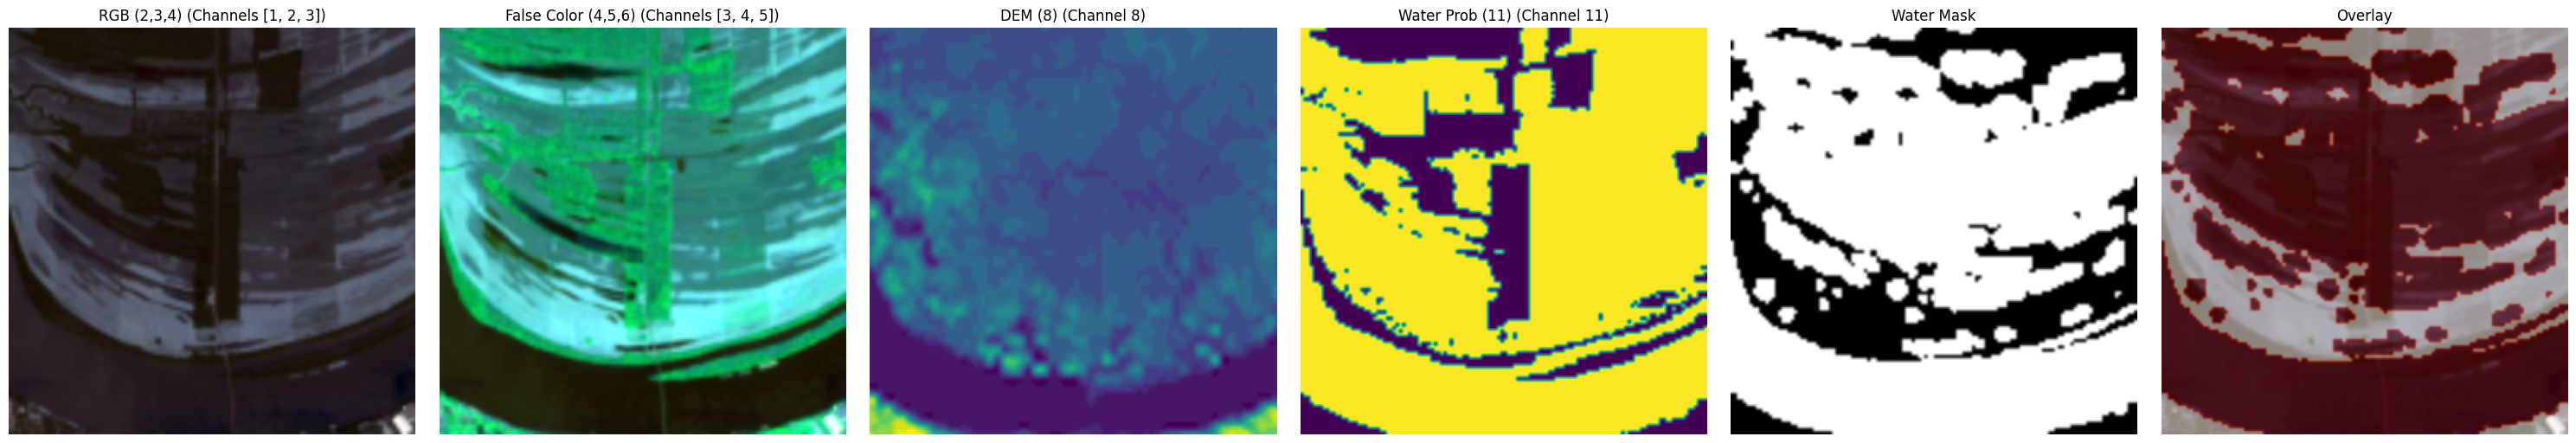

In [36]:
# Visualize a sample with different channel combinations
channel_groups = {
    'RGB (2,3,4)': [1, 2, 3],  # Blue, Green, Red (0-indexed: 1,2,3)
    'False Color (4,5,6)': [3, 4, 5],  # Red, NIR, SWIR1
    'DEM (8)': [8],  # Merit DEM
    'Water Prob (11)': [11]  # Water occurrence probability
}
data_loader.visualize_sample(0, channel_groups)

In [37]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 195
Validation samples: 49
Test samples: 62


In [38]:
# Build and compile model
print("Building model...")
model = EnhancedSegmentationModel(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))
model.compile_model(learning_rate=0.001)

Building model...


In [39]:
# Display model architecture
model.model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 256, 256,  │      3,488 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 256, 256,  │      9,248 │ activation_66[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 256, 256,  │        416 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 256, 256,  │          0 │ add_39[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ activation_67[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 128, 128,  │     36,928 │ activation_68[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 128, 128,  │      2,112 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_121[0][0]

 Total params: 8,570,567 (32.69 MB)

 Trainable params: 8,559,815 (32.65 MB)

 Non-trainable params: 10,752 (42.00 KB)

In [40]:
# Train model
print("Training model...")
history = model.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=16)

Training model...
X_train shape: (195, 256, 256, 12)
y_train shape: (195, 256, 256, 1)
X_val shape: (49, 256, 256, 12)
y_val shape: (49, 256, 256, 1)
Epoch 1/100


I0000 00:00:1758220199.864385      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-18 18:30:22.897807: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,96,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,256,256]{3,2,1,0}, f32[16,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-18 18:30:23.016609: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.118922257s
Trying algorithm eng0{} for conv (f32[32,96,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,256,256]{3,2,1,0}, f32[16,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targ

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - aux_output1_iou_score: 0.3316 - aux_output1_loss: 1.6219 - aux_output2_dice_coefficient: 0.4629 - aux_output2_loss: 1.7213 - loss: 2.8051 - main_output_accuracy: 0.7714 - main_output_loss: 1.4778

E0000 00:00:1758220243.671043      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758220243.915024      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


13/13 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - aux_output1_iou_score: 0.3384 - aux_output1_loss: 1.5919 - aux_output2_dice_coefficient: 0.4706 - aux_output2_loss: 1.6944 - loss: 2.7582 - main_output_accuracy: 0.7797 - main_output_loss: 1.4590 - val_aux_output1_iou_score: 0.4338 - val_aux_output1_loss: 5.4382 - val_aux_output2_dice_coefficient: 0.5685 - val_aux_output2_loss: 5.4388 - val_loss: 13.3992 - val_main_output_accuracy: 0.6599 - val_main_output_loss: 8.0169 - learning_rate: 0.0010
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_main_output_iou_score` which is not available. Available metrics are: aux_output1_iou_score,aux_output1_loss,aux_output2_dice_coefficient,aux_output2_loss,loss,main_output_accuracy,main_output_loss,val_aux_output1_iou_score,val_aux_output1_loss,val_aux_output2_dice_coefficient,val_aux_output2_loss,val_loss,val_main_output_accuracy,val_main_output_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_main_output_iou_score available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - aux_output1_iou_score: 0.4493 - aux_output1_loss: 1.1804 - aux_output2_dice_coefficient: 0.6318 - aux_output2_loss: 1.1890 - loss: 2.0872 - main_output_accuracy: 0.8675 - main_output_loss: 1.1469 - val_aux_output1_iou_score: 0.4335 - val_aux_output1_loss: 8.6821 - val_aux_output2_dice_coefficient: 0.5529 - val_aux_output2_loss: 1.9866 - val_loss: 11.2087 - val_main_output_accuracy: 0.8032 - val_main_output_loss: 4.4583 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - aux_output1_iou_score: 0.5223 - aux_output1_loss: 1.0964 - aux_output2_dice_coefficient: 0.6862 - aux_output2_loss: 1.1289 - loss: 1.9630 - main_output_accuracy: 0.8769 - main_output_loss: 1.0828 - val_aux_output1_iou_score: 0.4977 - val_aux_output1_loss: 2.7890 - val_aux_output2_dice_coefficient: 0.2668 - val_aux_output2_loss: 3.6128 - val_loss: 7.6495 - val_main_output_accuracy: 0.7955 - val_main_output_loss: 4.0885 - learning_rate: 0.0010
Epoch 4/1

In [42]:
print(history.history.keys())

dict_keys(['aux_output1_iou_score', 'aux_output1_loss', 'aux_output2_dice_coefficient', 'aux_output2_loss', 'loss', 'main_output_accuracy', 'main_output_loss', 'val_aux_output1_iou_score', 'val_aux_output1_loss', 'val_aux_output2_dice_coefficient', 'val_aux_output2_loss', 'val_loss', 'val_main_output_accuracy', 'val_main_output_loss', 'learning_rate'])


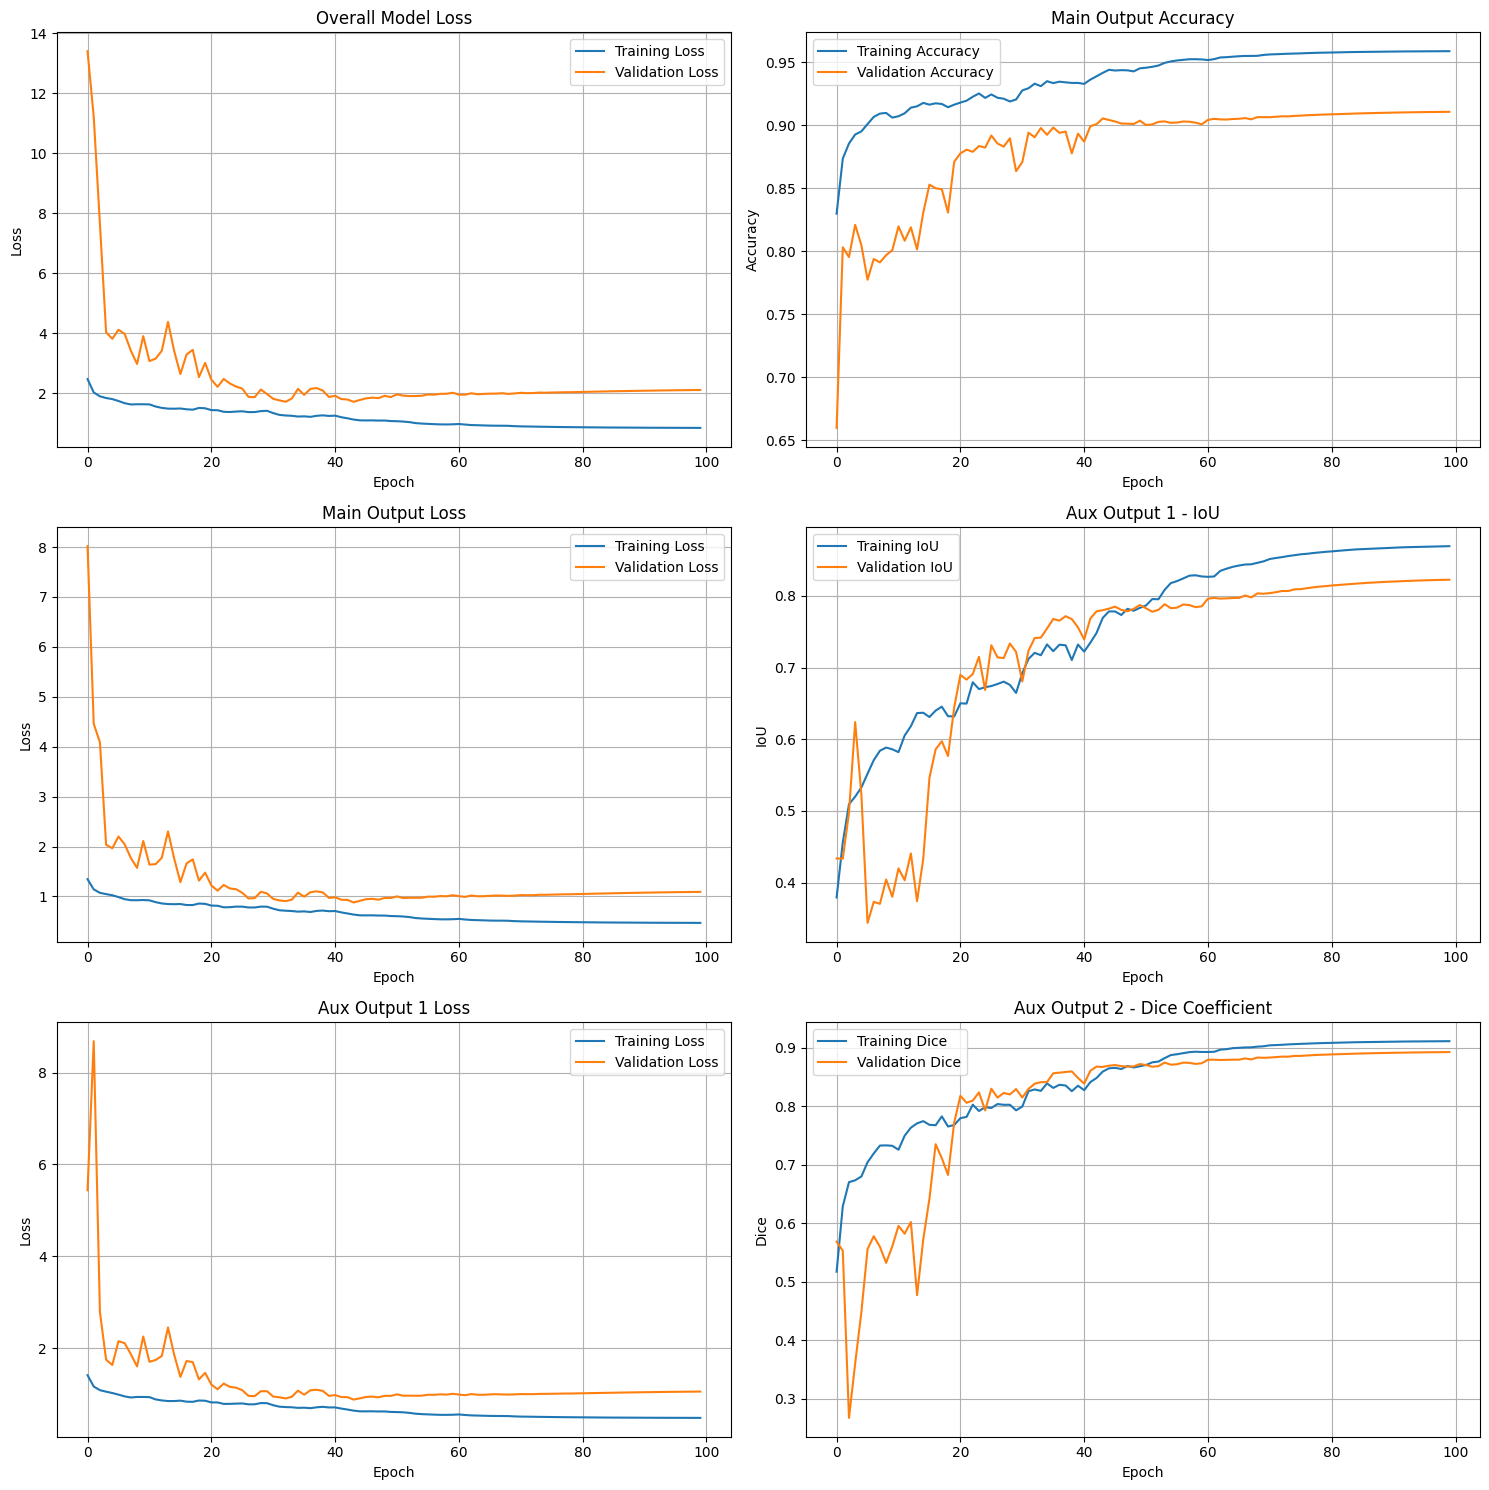

In [45]:
# Plot training history
plot_training_history(history)

In [46]:
# Evaluate model
print("Evaluating model...")
test_results = model.evaluate(X_test, y_test)
print("Test Results:")
for metric, value in test_results.items():
    if 'main_output' in metric:  # Only show main output metrics
        print(f"{metric}: {value:.4f}")

Evaluating model...


E0000 00:00:1758221483.484569     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758221483.739283     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Test Results:
main_output_loss: 1.2034


In [47]:
# Generate predictions
y_pred = model.model.predict(X_test)
y_pred_main = y_pred[0]  # Get main output predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


In [48]:
# Apply post-processing to refine boundaries
y_pred_refined = refine_predictions(y_pred_main)

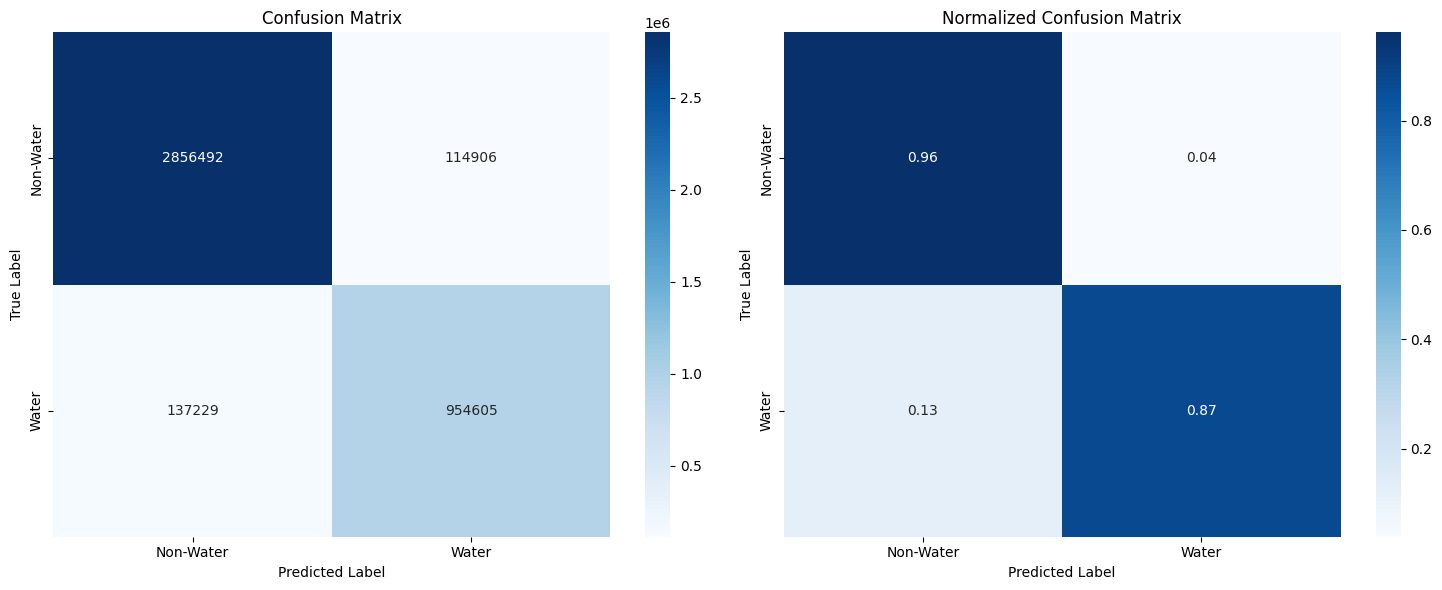

Classification Report:
              precision    recall  f1-score   support

   Non-Water       0.95      0.96      0.96   2971398
       Water       0.89      0.87      0.88   1091834

    accuracy                           0.94   4063232
   macro avg       0.92      0.92      0.92   4063232
weighted avg       0.94      0.94      0.94   4063232

IoU (Jaccard) Score: 0.7911


In [49]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_refined)

In [50]:
# Calculate boundary IoU
biou = boundary_iou(y_test, y_pred_refined)
print(f"Boundary IoU: {biou:.4f}")

Boundary IoU: 0.1186


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


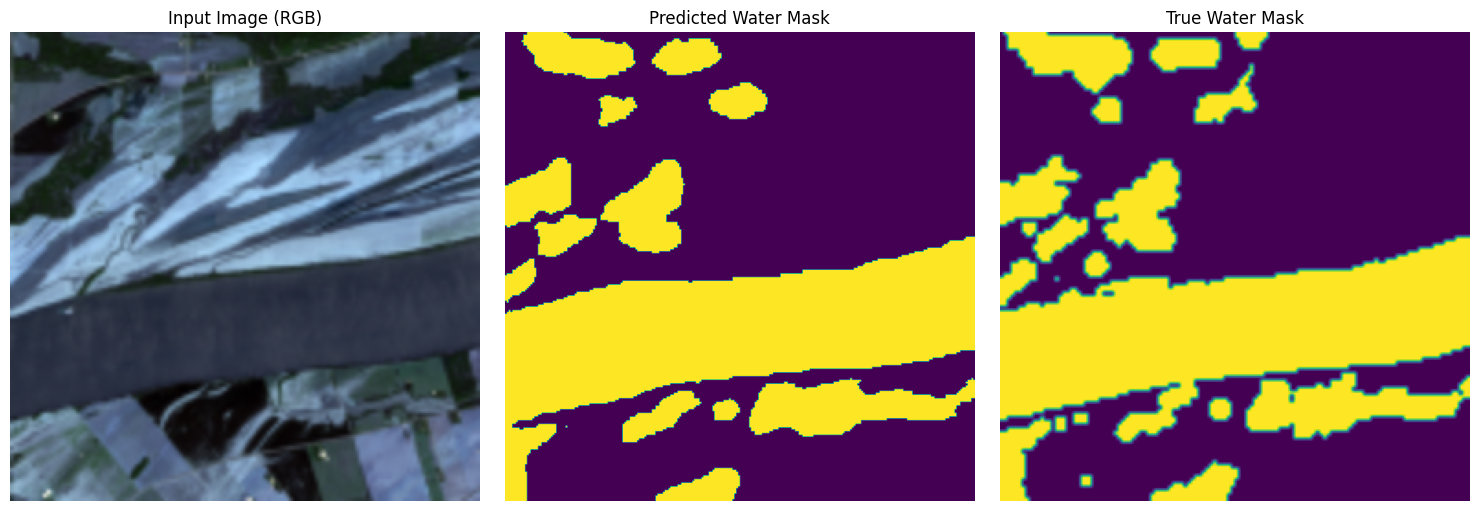

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


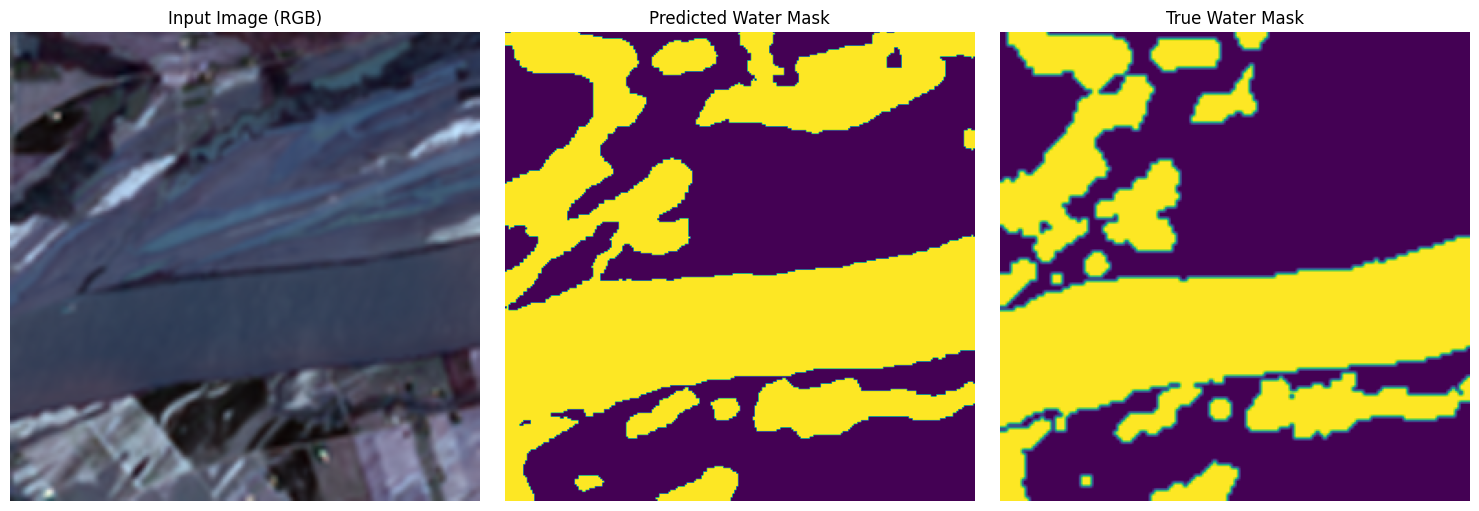

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


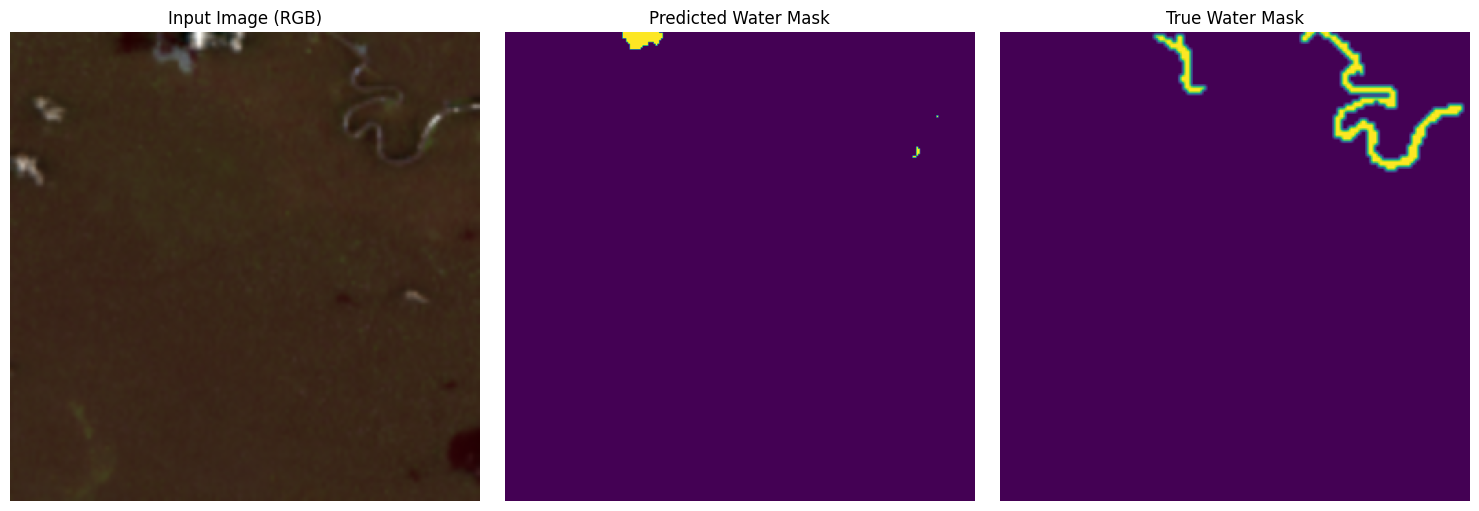

In [51]:
# Visualize some predictions
for i in range(3):
    model.visualize_prediction(X_test[i], y_test[i])

In [52]:
# Save the model
model.model.save('water_segmentation_model.h5')
print("Model saved as 'enhanced_water_segmentation_model.h5'")

Model saved as 'enhanced_water_segmentation_model.h5'


In [54]:
model.model.save("my_model.keras")   # new recommended format

In [56]:
model.model.export("my_model")   # creates a folder "my_model/"


Saved artifact at 'my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 12), dtype=tf.float32, name='keras_tensor_405')
Output Type:
  List[TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)]
Captures:
  136746058785680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058786256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058786640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058786832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058783952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058786064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058790672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136746058791248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13674